In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
r = random.Random(2147483647)
r.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182546, 4]) torch.Size([182546])
torch.Size([22840, 4]) torch.Size([22840])
torch.Size([22760, 4]) torch.Size([22760])


In [8]:
words[:n1][:5], words[n1:n2][:5], words[n2:][:5]

(['khole', 'harbour', 'devon', 'baine', 'erisha'],
 ['shterna', 'tyanna', 'sarra', 'malachy', 'zenaya'],
 ['phoenyx', 'christionna', 'bastien', 'niloufar', 'masa'])

In [9]:
C = torch.randn((27, 2))

In [10]:
emb = C[X[:32]]
emb.shape

torch.Size([32, 3, 2])

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [13]:
h

tensor([[ 0.9451, -0.0595, -0.5417,  ...,  0.9689,  0.3147, -0.9997],
        [ 0.9637, -0.4113, -0.6137,  ...,  0.9037,  0.5153, -0.9997],
        [ 1.0000, -0.9898, -0.9972,  ...,  0.9841,  0.9999, -0.6239],
        ...,
        [ 0.9974,  0.7850, -0.9778,  ..., -0.7685,  0.9871,  0.2487],
        [ 0.9787, -0.7700, -0.5126,  ..., -0.9884,  0.5715, -0.6885],
        [ 0.8685, -0.1113,  0.2319,  ..., -0.8159, -0.9972, -0.9483]])

In [14]:
h.shape

torch.Size([32, 100])

In [15]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [16]:
logits = h @ W2 + b2

In [17]:
logits.shape

torch.Size([32, 27])

In [18]:
counts = logits.exp()

In [19]:
prob = counts / counts.sum(1, keepdims=True)

In [20]:
prob.shape

torch.Size([32, 27])

In [21]:
loss = -prob[torch.arange(32), Y[:32]].log().mean()
loss

tensor(23.4241)

In [22]:
# E02: I was not careful with the intialization of the network in this video. 
# (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 
# (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [23]:
# perfectly uniform probabilities for 27 classes are 1/27
# lets compute nll over this probability
-torch.log(torch.tensor(1/27))

tensor(3.2958)

In [24]:
# to get perfectly uniform probabilities from network we need to initialize weights with same value
# that brings symmetry, all neurons will produce same activations and gradients, and
# eventually we can't learn anything. But to confirm init loss for uniformly distributed probs lets do it
C = torch.ones((27, 2))
emb = C[X[:32]]
W1 = torch.ones(6, 100)
b1 = torch.zeros(100)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
W2 = torch.ones((100, 27))
b2 = torch.zeros(27)
logits = h @ W2 + b2

# logits -= logits.max() # for numerical stability
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# -prob[torch.arange(32), Y[:32]].log().mean()

# or with X-entropy
F.cross_entropy(logits, Y[:32])

tensor(3.2958)

In [25]:
# Lets go ahead and take a look at what loss do we achieve with naive initialization. See below.
# To answer the (2) we want less spread [variance] for our neuron weights, and as far as we learned elsewhere
# if s = w*x, then var(s) = n*var(w)*var(x) [n is the number of inputs into weights matrix w]. To make activation
# variance closer to 1 (not exploding, not vanishing activations), we need to scale weights by sqrt(1/n) or 
# for relu networks (as their variance already reduced by half) by sqrt(2/n)
# And as we can see below, by using this neat trick we can have loss at init to be very close to fully uniform init loss

In [26]:
# ------------ now made respectable :) ---------------

In [27]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182546, 4]), torch.Size([182546]))

In [113]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
emb_size = 10
C = torch.randn((27, emb_size), generator=g) * (2/27)**0.5
W1 = torch.randn((emb_size * block_size, 512), generator=g) * (2/(emb_size * block_size))**0.5
b1 = torch.zeros(512)
W2 = torch.randn((512, 27), generator=g) * (2/527)**0.5
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]

In [50]:
emb = C[Xtr] # (Xtr size, 3, 2)
h = torch.tanh(emb.view(-1, emb_size * block_size) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(f'Naive initialization loss: {loss}')

Naive initialization loss: 41.57704544067383


In [114]:
emb = C[Xtr] # (Xtr size, 3, 2)
h = F.relu(emb.view(-1, emb_size * block_size) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(f'Scaled initialization loss: {loss}')

Scaled initialization loss: 3.4736976623535156


In [115]:
sum(p.nelement() for p in parameters) # number of parameters in total

35113

In [116]:
for p in parameters:
  p.requires_grad = True

In [110]:
lre = torch.linspace(-6, 0, 1000)
lrs = 10**lre

In [111]:
# find learning rate
lri = []
lossi = []

for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (256,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = F.relu(emb.view(-1, emb_size * block_size) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

#print(loss.item())

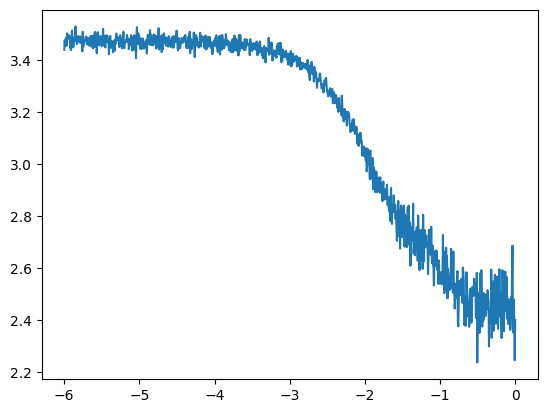

In [112]:
plt.plot(lri, lossi)

In [117]:
lossi = []
reg_strength = 1.0
for i in range(200000):
  
  # minibatch construct (use same batch sequencies across experiments)
  ix = torch.randint(0, Xtr.shape[0], (512,), generator=g)
  
  # forward pass
  emb = C[Xtr[ix]] # (minibatch size, block size, embeeding size)
  h = F.relu(emb.view(-1, emb_size * block_size) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  reg_loss = 0.5 * reg_strength * sum([(p**2).mean() for p in parameters]) # const 0.5 for better gradient = reg_strength * p
  loss = F.cross_entropy(logits, Ytr[ix]) + reg_loss
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.2 if i < 100000 else 0.02
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  lossi.append(loss.log10().item())

#print(loss.item())

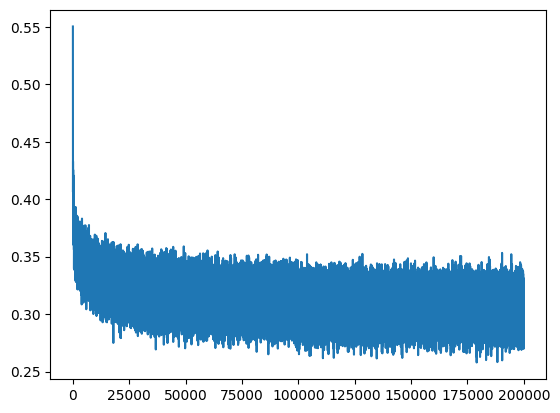

In [118]:
plt.plot(lossi)

In [119]:
emb = C[Xtr] # (Xtr size, 3, 2)
h = F.relu(emb.view(-1, emb_size * block_size) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9096, grad_fn=<NllLossBackward0>)

In [120]:
emb = C[Xdev] # (Xdev size, 3, 2)
h = F.relu(emb.view(-1, emb_size * block_size) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0232, grad_fn=<NllLossBackward0>)

In [ ]:
# AK original hyperparameters [embeding size: 10, hlayer: 200, init lr: 0.1, decayed lr: 0.01, decay after 100000 iters, epochs: 200000, bs: 32]. Loss: tr=2.1294, dev=2.1858
# lr with loss deeper in find lr [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 100000 iters, epochs: 200000, bs: 32]. Loss: tr=2.1194, dev=2.1850
# train longer? [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 32]. Loss: tr=2.0984, dev=2.1716
# larger embeeding? [embeding size: 15, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 32]. Loss: tr=2.0893, dev=2.1738
# larger minibatch? [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 128]. Loss: tr=2.0447, dev=2.1331
# larger minibatch? [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256]. Loss: tr=2.0449, dev=2.1295
# larger minibatch? [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 512]. Loss: tr=2.0529, dev=2.1313
# larger hidden layer? [embeding size: 10, hlayer: 256, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256]. Loss: tr=2.0347, dev=2.1314
# larger hidden layer? [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256]. Loss: tr=1.9835, dev=2.1572
# reg loss [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.001]. Loss: tr=1.9872, dev=2.1477
# reg loss [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.01]. Loss: tr=1.9907, dev=2.1452
# With reg loss established, things tend to improve with larger capacity network
# reg loss [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.1]. Loss: tr=1.9845, dev=2.1002
# reg loss [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=2.0300, dev=2.0951
# reg loss [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=1.9902, dev=2.0797
# reg loss [embeding size: 15, hlayer: 512, init lr: 0.3, decayed lr: 0.03, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=1.9888, dev=2.0806
# relu [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=2.0206, dev=2.0926

# proper init [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 1.*]. Loss: tr=2.0313, dev=2.0974
# proper init [embeding size: 15, hlayer: 512, init lr: 0.1, decayed lr: 0.01, decay after 100000 iters, epochs: 200000, bs: 256, reg strength: 1.*]. Loss: tr=2.0690, dev=2.1160
# proper init [embeding size: 15, hlayer: 512, init lr: 0.1, decayed lr: 0.01, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 1.*]. Loss: tr=2.0464, dev=2.1036
# proper init [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.1*]. Loss: tr=1.9206, dev=2.0972
# proper init [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5*]. Loss: tr=1.9721, dev=2.0820
# proper init [embeding size: 15, hlayer: 512, lrs: [0.2,0.04,0.02], decay after [100k, 200k], epochs: 300000, bs: 256, reg strength: 0.5*]. Loss: tr=1.987, dev=2.0833
# proper init [embeding size: 15, hlayer: 512, lrs: [0.2,0.04], decay after [200k], epochs: 300000, bs: 256, reg strength: 0.5*]. Loss: tr=1.9673, dev=2.0848
# proper init [embeding size: 15, hlayer: 512, lrs: [0.2,0.04], decay after [150k], epochs: 300000, bs: 256, reg strength: 0.5*]. Loss: tr=1.9726, dev=2.0856
# proper init [embeding size: 15, hlayer: 512, lrs: [0.2,0.02], decay after [150k], epochs: 300000, bs: 256, reg strength: 0.25*]. Loss: tr=1.9418, dev=2.0847
# proper init [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 512, reg strength: 0.5*]. Loss: tr=1.9573, dev=2.0793
# proper init relu [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 512, reg strength: 0.5*]. Loss: tr=1.9568, dev=2.0759  /with relu loss drops much faster/
# proper init relu [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 70000 iters, epochs: 100000, bs: 512, reg strength: 0.5*]. Loss: tr=1.9830, dev=2.0800
# proper init relu [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 70000 iters, epochs: 100000, bs: 512, reg strength: 0.5*]. Loss: tr=2.0140, dev=2.0893

# block size 4 [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 70000 iters, epochs: 100000, bs: 512, reg strength: 0.5*]. Loss: tr=1.8875, dev=2.0257
# block size 4 [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 100000 iters, epochs: 200000, bs: 512, reg strength: 0.5*]. Loss: tr=1.8615, dev=2.0243
# block size 4 [embeding size: 10, hlayer: 512, init lr: 0.1, decayed lr: 0.02, decay after 100000 iters, epochs: 200000, bs: 512, reg strength: 0.5*]. Loss: tr=1.8981, dev=2.0298
# block size 4 [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 100000 iters, epochs: 200000, bs: 512, reg strength: 1.0*]. Loss: tr=1.9045, dev=2.0233, test=2.0120

# C init, block size 4 [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 100000 iters, epochs: 200000, bs: 512, reg strength: 1.0*]. Loss: tr=1.9096, dev=2.0232, 2.0153

# 2 hiden layers [embeding size: 15, hlayer: [512,256], init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=1.9744, dev=2.1024

# *after introducing 0.5 constant to regularization loss for simplier gradient term

In [121]:
emb = C[Xte]
h = F.relu(emb.view(-1, emb_size * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.0153, grad_fn=<NllLossBackward0>)

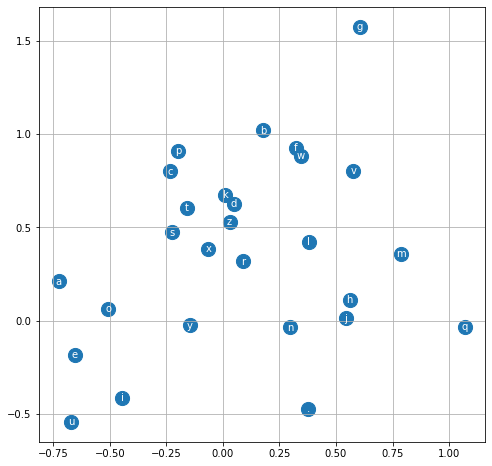

In [710]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [52]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [125]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 11)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = F.relu(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

reena.
kriston.
gara.
nearyan.
naker.
malyah.
roxane.
kyree.
meev.
hamelle.
krishiannaliee.
kenli.
maurik.
deles.
lorena.
wassiduq.
resle.
monser.
aflarijalyna.
merah.
